In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator
from typing import Callable, Tuple, List
from scipy.linalg import cholesky, solve_triangular
from sklearn.preprocessing import StandardScaler

In [2]:
path="/home/jorgebdelafuente/Doctorado/PH2M/Sings/"
dm_entry_11 = np.loadtxt(path+"entry/dm_1.1.dat")
dm_entry_12 = np.loadtxt(path+"entry/dm_1.2.dat")
dm_exit_11 = np.loadtxt(path+"exit/dm_1.1.dat")
dm_exit_12 = np.loadtxt(path+"exit/dm_1.2.dat")

In [3]:
def get_ic(rg,rp,theta):
    thrad=np.radians(theta)
    r12=((rp*0.50)*(rp*0.50)+rg*rg-2.0*0.50*rp*rg*np.cos(thrad))**0.50
    r13=((rp*0.50)*(rp*0.50)+rg*rg-2.0*0.50*rp*rg*np.cos(np.pi-thrad))**0.50
    r23=rp
    return r12,r13,r23

In [4]:
dm_11_entry_ic = np.zeros((len(dm_entry_11), 6))
dm_12_entry_ic = np.zeros((len(dm_entry_12), 6))

for i in range(len(dm_entry_11)):
    r12, r13, r23 = get_ic(dm_entry_11[i, 0], dm_entry_11[i, 1], dm_entry_11[i, 1])
    # coge las columnas 3,4,5 (índices 3:6)
    dm_11_entry_ic[i, :] = np.array([r12, r13, r23,
                                    dm_entry_11[i, 3], dm_entry_11[i, 4], dm_entry_11[i, 5]])

for i in range(len(dm_entry_12)):
    r12, r13, r23 = get_ic(dm_entry_12[i, 0], dm_entry_12[i, 1], dm_entry_12[i, 2])
    dm_12_entry_ic[i, :] = np.array([r12, r13, r23,
                                    dm_entry_12[i, 3], dm_entry_12[i, 4], dm_entry_12[i, 5]])


In [5]:
dm_mod_11 = np.zeros((len(dm_11_entry_ic)+len(dm_exit_11), 4))
dm_mod_12 = np.zeros((len(dm_12_entry_ic)+len(dm_exit_12), 4))

def fill_mod(out, first, second):
    n1 = len(first)
    out[:n1, :3] = first[:, :3]
    out[:n1,  3] = np.linalg.norm(first[:, 3:6], axis=1)
    out[n1:, :3] = second[:, :3]
    out[n1:,  3] = np.linalg.norm(second[:, 3:6], axis=1)

fill_mod(dm_mod_11, dm_11_entry_ic, dm_exit_11)
fill_mod(dm_mod_12, dm_12_entry_ic, dm_exit_12)

np.savetxt(path+"dm_entry_11_ic.dat", np.column_stack([dm_11_entry_ic[:,:3],np.linalg.norm(dm_11_entry_ic[:,3:6], axis=1)]))
np.savetxt(path+"dm_entry_12_ic.dat", np.column_stack([dm_12_entry_ic[:,:3],np.linalg.norm(dm_12_entry_ic[:,3:6], axis=1)]))
np.savetxt(path+"dm_exit_11.dat", np.column_stack([dm_exit_11[:,:3],np.linalg.norm(dm_exit_11[:,3:6], axis=1)]))
np.savetxt(path+"dm_exit_12.dat", np.column_stack([dm_exit_12[:,:3],np.linalg.norm(dm_exit_12[:,3:6], axis=1)]))
np.savetxt(path+"dm_mod_11.dat", dm_mod_11)
np.savetxt(path+"dm_mod_12.dat", dm_mod_12)

In [6]:
# Tus datos: distancias y momento dipolar
x = np.column_stack((dm_mod_11[:,0], dm_mod_11[:,1], dm_mod_11[:,2]))  # distancias
mu  = dm_mod_11[:,3]   # el módulo del dipolo
best_eps=0.46415888336127775 
# Interpolador RBF
# rbf_11_MQ = RBFInterpolator(x, mu, kernel="multiquadric", epsilon=best_eps, degree=0, smoothing=1e-8)
rbf_11_MQ = RBFInterpolator(x, mu, kernel="gaussian", epsilon=best_eps, degree=2, smoothing=1e-5)
# rbf_11_MQ = RBFInterpolator(x, mu, kernel="cubic", degree=3, smoothing=1e-8)

Max difference (1.1): 0.8858499324959701


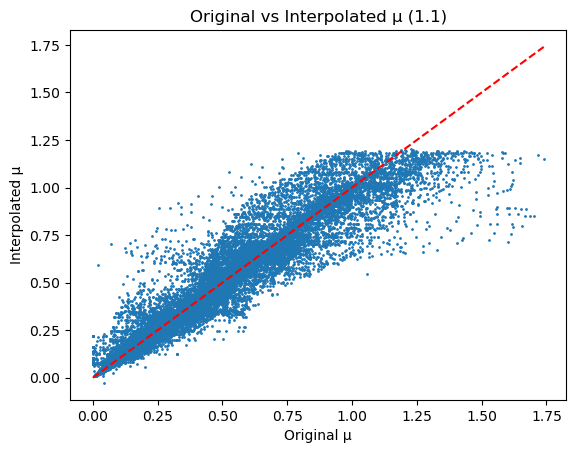

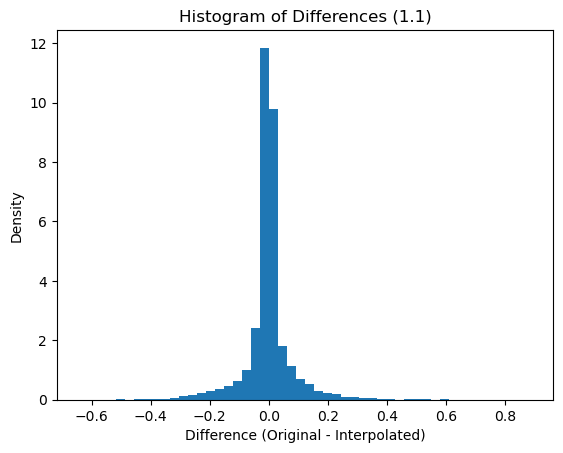

In [7]:
# Checking original vs interpolated
mu_interp_11 = rbf_11_MQ(x)
diff_11 = mu - mu_interp_11
print(f"Max difference (1.1): {np.max(np.abs(diff_11))}")   

fig, ax = plt.subplots()
ax.scatter(mu, mu_interp_11, s=1)
ax.plot([mu.min(), mu.max()], [mu.min(), mu.max()], 'r--')
ax.set_xlabel('Original μ')
ax.set_ylabel('Interpolated μ')
ax.set_title('Original vs Interpolated μ (1.1)')
plt.show() 

fig1, ax1 = plt.subplots()
ax1.hist(diff_11, bins=50, density=True)
ax1.set_xlabel('Difference (Original - Interpolated)')  
ax1.set_ylabel('Density')
ax1.set_title('Histogram of Differences (1.1)')
plt.show() 

In [8]:
err_vec = diff_11
rmse_vec = np.sqrt(np.mean(err_vec**2, axis=0))   # por componente

print("RMSE componentes [mux, muy, muz]:", rmse_vec)

RMSE componentes [mux, muy, muz]: 0.08347523675086739


# Escalado de coordenadas para RBF inteporlator

##### Dos tipos de escalados:

**Z-score**: 

- Cuándo no se tiene una escala física clara.
- Por coordenada, se resta la media y se divide por la desviación típica.
- Cada coordenada tiene un "peso parecido" en la distancia para cada DOF.


In [47]:
# Crear escalador de las coordenadas:
class ZscoreScaler:
    def fit(self,X): 
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0, ddof=0)
        self.scale_[self.scale_ == 0.0] = 1.0
        return self
    def transform(self,X):
        return (X - self.mean_) / self.scale_
    def fit_transform(self,X):
        return self.fit(X).transform(X)
    def inverse_transform(self,X):
        return X * self.scale_ + self.mean_
    
scaler = ZscoreScaler()
x_scaled = scaler.fit_transform(x)

rbf_11_MQ_scaled = RBFInterpolator(x_scaled, mu, kernel="gaussian", epsilon=best_eps, degree=2, smoothing=1e-5)

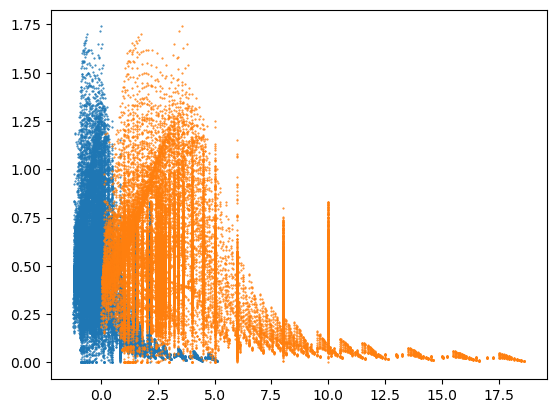

In [55]:
fig, ax = plt.subplots()
ax.plot(x_scaled[:,0],mu,'o',ms=0.5,lw=0.5,label='Original')
ax.plot(x[:,0],mu,'o',ms=0.5,lw=0.5,label='Original')

Max difference (1.1): 1127.0076194194205


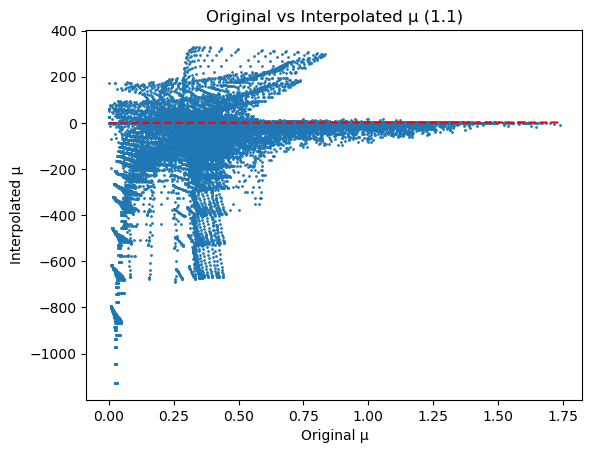

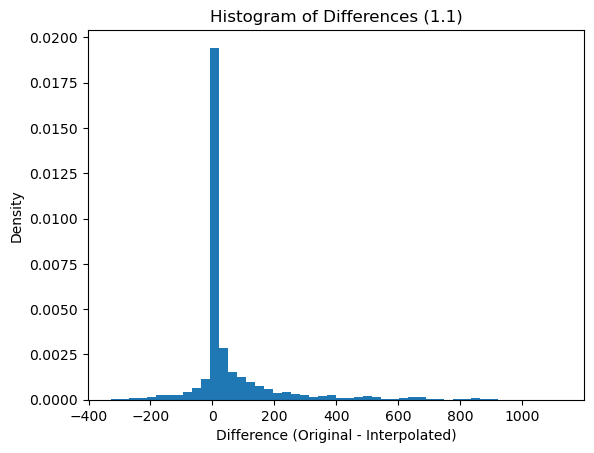

In [48]:
# Checking original vs interpolated
mu_interp_11 = rbf_11_MQ_scaled(x)
diff_11 = mu - mu_interp_11
print(f"Max difference (1.1): {np.max(np.abs(diff_11))}")   

fig, ax = plt.subplots()
ax.scatter(mu, mu_interp_11, s=1)
ax.plot([mu.min(), mu.max()], [mu.min(), mu.max()], 'r--')
ax.set_xlabel('Original μ')
ax.set_ylabel('Interpolated μ')
ax.set_title('Original vs Interpolated μ (1.1)')
plt.show() 

fig1, ax1 = plt.subplots()
ax1.hist(diff_11, bins=50, density=True)
ax1.set_xlabel('Difference (Original - Interpolated)')  
ax1.set_ylabel('Density')
ax1.set_title('Histogram of Differences (1.1)')
plt.show() 


In [50]:
err_vec = diff_11
rmse_vec = np.sqrt(np.mean(err_vec**2, axis=0))   # por componente

print("RMSE mu total:", rmse_vec)

RMSE mu total: 160.61698887078535


# Prueba de método de análisis LOO y PRESS para RBF interpolation

##### Interpolación RBF

La interpolación RBF consiste en:

$ s(x) = \Sigma_j c_j \phi (\vert x -x_j \vert) $, 

dónde,  el "kernel" ($\phi$) se define como una función, que puede ser gaussiana, multicuadrática, cúbica, polinómica... En este problema me voy a centrar en:

- Multicuadrática: $\phi(r) = \sqrt(1+(\epsilon r)^2)$ 
- Inversa MC: $\phi(r) = 1/\sqrt(1+(\epsilon r)^2)$ 
- Gausiana: $\phi(r) = \exp(-(\epsilon r)^2)$
- Polinómicas de orden 3 y 5.

$\epsilon$ controla el alcance/curvatura de la función para cada punto.

El ajuste se hace resolviendo la matriz del Kernel ($K_{ij} = \phi(\vert x_i - x_j\vert;\epsilon)$) con:

$(K+\lambda I)c = y$. Si $M = (K+\lambda I)^{-1}$, entonces: $c=My$.

##### Problema 

Como es una interpolación, es muy díficil hacer un análisis correcto del ajuste, ya que los puntos originales del set, siempre van a dar un error de 0 o muy pequeño. Por lo tanto, una manera de analizar este problema es usando el método Leave-One-Out / Predicted Residual Sum of Squares (LOO/PRESS). 

El método LOO consiste en hacer excluir todos los puntos del set original 1 vez y comprobar con lo predicho en la interpolación, utilizando el estadístico $PRESS = \Sigma_i (e_i^{LOO})^2 = \Sigma_i (c_i/M_{ii})^2 $. El residulal LOO se define como $e_i^{LOO} = \hat{y}_i^{(-i)} - y_i = -c_i/M_{ii}$.

Sin embargo, no hace falta entrenar/realizar el ajuste N veces quitando un punto diferente cada vez, se puede hacer de manera eficiente haciendo uso de las relaciones que he mostrado anteriormente. Este método consiste en: 

- Factorizar la matriz del Kernel ($K_{\lambda} = K + \lambda I$) haciendo uso del método Cholesky, dónde: $K_\lambda = LL^T$ (L siendo la parte bajo la diagonal).
- Con las relaciones previas, se puede resolver $LL^Tc=y$ con dos sustituciones triangulares.
- La diagonal de M, siendo $M=L^{-T}L^{-1} \rightarrow M_{ii}=\vert \vert z_i \vert \vert ^2$, siendo $z_i$: $L z_i =e_i$. Siendo $e_i$ el vector canónico (unidad) con 1 en la i-ésima posición.
- Entonces, para cada i, se resuelve $L z_i =e_i$, computando $M_{ii} = z_i^Tz_i$

###### Por qué M_ii = z_i^T z_i?

- Cholesky: $K_λ = L L^T ⇒ M = K_λ^{-1} = L^{-T} L^{-1}$.
- Diagonal: $M_ii = e_i^T M e_i = e_i^T L^{-T} L^{-1} e_i = (L^{-1} e_i)^T (L^{-1} e_i)$.
- Define $z_i = L^{-1} e_i$, que se obtiene resolviendo $L z_i = e_i$ (sustitución hacia delante).
- Entonces $M_{ii} = ||z_i||^2 = z_i^T z_i$.

In [7]:
# Definición de los kernels

def kernel_factory(name:str,epsilon:float=1.0) -> Callable[[np.ndarray], np.ndarray]:
    """
    Devuelve phi(r) para el kernel especificado
    name puede ser: 'gaussian', 'cubic', 'quintic', 'multiquadric'
    """
    n=name.lower()
    if n=='gaussian':
        def phi(r):
            t = epsilon*r
            return np.exp(-(t*t))
        return phi
    elif n=='cubic':
        def phi(r):
            return r**3
        return phi
    elif n=='quintic':
        def phi(r):
            return r**5
        return phi
    elif n=='multiquadric':
        def phi(r):
            t = epsilon*r
            return np.sqrt(1.0 + t*t)
        return phi
    raise ValueError(f"Kernel '{name}' no reconocido")

# Obtener las distancias entre puntos
def pairwise_dist(X: np.ndarray) -> np.ndarray:
    X = np.asarray(X)
    diff = X[:, None, :] - X[None, :, :]
    return np.sqrt(np.sum(diff*diff, axis=2))

# Diagonalizar sin inversión LL^T
def _diag_inv_from_chol(L: np.ndarray, method: str = "loop") -> np.ndarray:
    """
    diag((L L^T)^{-1}) sin invertir explícitamente.
    method='I': resuelve L Z = I y usa diag = sum(Z^2, axis=0) (rápido, más memoria).
    method='loop': resuelve L z_i = e_i por columnas (menos memoria).
    """
    n = L.shape[0]
    if method == "I":
        Z = solve_triangular(L, np.eye(n), lower=True)
        return np.sum(Z*Z, axis=0)
    elif method == "loop":
        diagM = np.empty(n)
        for i in range(n):
            ei = np.zeros(n); ei[i] = 1.0
            zi = solve_triangular(L, ei, lower=True)
            diagM[i] = np.dot(zi, zi)
        return diagM
    else:
        raise ValueError("method debe ser 'I' o 'loop'")

In [8]:
# --- PRESS / LOO ---
def press_loocv(
    X: np.ndarray, y: np.ndarray, kernel: str = "gaussian",
    epsilon: float = 1.0, lam: float = 0.0,
    diag_method: str = "loop", return_all: bool = False
):
    """
    Calcula PRESS y residuos LOO sin reentrenar.
    Retorna: press, (e_loo, yhat_loo, c, diagM) si return_all=True.
    """
    X = np.asarray(X); y = np.asarray(y).ravel()
    n = len(y)
    phi = kernel_factory(kernel, epsilon)
    r = pairwise_dist(X)
    K = phi(r)
    Klam = K + lam * np.eye(n)
    L = cholesky(Klam, lower=True)
    # c = (K+λI)^{-1} y por sustituciones triangulares
    w = solve_triangular(L, y, lower=True)
    c = solve_triangular(L.T, w, lower=False)
    # diagM = diag((K+λI)^{-1})
    diagM = _diag_inv_from_chol(L, method=diag_method)
    e_loo = c / diagM
    press = float(e_loo @ e_loo)
    if return_all:
        yhat_loo = y - e_loo
        return press, e_loo, yhat_loo, c, diagM
    return press

def grid_search_press(
    X: np.ndarray, y: np.ndarray, kernel: str,
    eps_grid: np.ndarray, lam_grid: np.ndarray,
    diag_method: str = "loop"
) -> Tuple[float, float, float, List[Tuple[float,float,float]]]:
    """
    Devuelve (best_press, best_eps, best_lam, resultados[(press, eps, lam), ...]) ordenados por press.
    """
    results: List[Tuple[float,float,float]] = []
    for eps in eps_grid:
        for lam in lam_grid:
            try:
                pr = press_loocv(X, y, kernel, eps, lam, diag_method=diag_method, return_all=False)
                results.append((pr, float(eps), float(lam)))
            except np.linalg.LinAlgError:
                # No SPD (p.ej. λ demasiado pequeño)
                pass
    if not results:
        raise RuntimeError("Ninguna combinación produjo sistema SPD. Incrementa λ.")
    results.sort(key=lambda t: t[0])
    best_press, best_eps, best_lam = results[0]
    return best_press, best_eps, best_lam, results

In [9]:
# --- Predicción con el modelo elegido ---
def rbf_fit(
    X: np.ndarray, y: np.ndarray, kernel: str, epsilon: float, lam: float
) -> Tuple[np.ndarray, Callable[[np.ndarray], np.ndarray]]:
    """
    Ajusta RBF con (kernel, ε, λ) y devuelve (c, predictor(Xq) -> yq).
    """
    X = np.asarray(X); y = np.asarray(y).ravel()
    n = len(y)
    phi = kernel_factory(kernel, epsilon)
    K = phi(pairwise_dist(X))
    Klam = K + lam * np.eye(n)
    L = cholesky(Klam, lower=True)
    w = solve_triangular(L, y, lower=True)
    c = solve_triangular(L.T, w, lower=False)

    def predict(Xq: np.ndarray) -> np.ndarray:
        Xq = np.asarray(Xq)
        # distancias query-train
        diff = Xq[:, None, :] - X[None, :, :]
        R = np.sqrt(np.sum(diff*diff, axis=2))
        Kqx = phi(R)
        return Kqx @ c

    return c, predict

In [12]:
# Construye X y máscara
r12, r13, r23 = dm_mod_11[:,0], dm_mod_11[:,1], dm_mod_11[:,2]
X = np.column_stack([r12, r13, r23]).astype(float)
y = mu.astype(float)

mask = (r12 < 5) & (r13 < 5) & (r23 < 5)
X_mask = X[mask]
y_mask = y[mask]

print(f"Datos totales: {len(y)}, tras máscara: {len(y_mask)}")

rng = np.random.default_rng(0)
m = 1000                          # p.ej., 3k–5k para LOO denso
idx = rng.choice(len(y_mask), size=m, replace=False)
X_sub = X_mask[idx]
y_sub = y_mask[idx]


Datos totales: 32767, tras máscara: 13481


In [13]:
# Barrido (gaussiana como ejemplo)
eps_grid = np.logspace(-2, 2, 13)
lam_grid = np.r_[0.0, np.logspace(-12, -3, 10)]

best_press, best_eps, best_lam, _ = grid_search_press(X_sub, y_sub, "gaussian", eps_grid, lam_grid)
print(best_press, best_eps, best_lam)

# Ajuste final y predicción
c, predict = rbf_fit(X_sub, y_sub, "gaussian", best_eps, best_lam)
y_fit = predict(X_sub)
rmse_train = np.sqrt(np.mean((y_fit - y_sub)**2))

# LOO/PRESS detallado con esos hiperparámetros
press, e_loo, yhat_loo, c2, diagM = press_loocv(X_sub, y_sub, "gaussian", best_eps, best_lam, return_all=True)
rmse_loo = np.sqrt(press / len(y_sub))
print("RMSE train:", rmse_train, "RMSE LOO:", rmse_loo)

10.95887331024736 0.46415888336127775 0.0001
RMSE train: 0.09484046826178442 RMSE LOO: 0.10468463741279023


# Segundo enfoque: LOO/PRESS "MONTE CARLO"

El problema con el enfoque LOO/PRESS normal es el alto coste, que incluso con 1000 puntos se va a ~2 min sin ofrecer tampoco el mejor resultado, además de que el factor de aleatoriedad es un problema. 

Entonces, el siguiente enfoque es hacer una selección aleatoria de todos los puntos pero con más densidad y entonces obtener el PRESS que se extrae al hacer la diferencia entre los valores originales no incluidos y lo predicho.

In [77]:
# --- Validación hold-out ---
# Divide en train/test
rng = np.random.default_rng(0)
N = len(X)
m = 25000  # ojo con m muy grande (ver nota abajo)

idx_train = rng.choice(N, size=N, replace=False)
idx_test = np.setdiff1d(np.arange(N), idx_train, assume_unique=False)

kernel_type = "cubic"  # "gaussian" | "multiquadric" | "cubic" | "quintic"
best_eps = 0.46415888336127775
smoothing = 1e-8

X_train, y_train = X[idx_train], y[idx_train]
X_test, y_test = X[idx_test], y[idx_test]

if kernel_type in ("gaussian", "multiquadric"):
    mu_pred = RBFInterpolator(X[idx_train], y[idx_train],
                            kernel=kernel_type, epsilon=best_eps, smoothing=smoothing)
else:
    mu_pred = RBFInterpolator(X[idx_train], y[idx_train],
                            kernel=kernel_type, smoothing=smoothing)




In [81]:
y_hat = mu_pred(X[idx_train])
rmse = float(np.sqrt(np.mean((y_hat - y[idx_train])**2)))
print("RMSE hold-out:", rmse)

RMSE hold-out: 0.07115123066601144


In [79]:
def median_dist(X, nsample=5000, seed=0):
    rng = np.random.default_rng(seed)
    Xs = X[rng.choice(len(X), size=min(nsample, len(X)), replace=False)]
    d = np.linalg.norm(Xs[:, None, :] - Xs[None, :, :], axis=2)
    return float(np.median(d[d > 0]))

med = median_dist(X)
for c in (0.8, 1.0, 1.5, 2.0):
    eps = c / med

In [83]:
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import Delaunay, cKDTree

def _ensure_close_mask(X, fixed_dim, fixed_val, tol, min_pts=200, max_iter=5, grow=1.5):
    mask = np.abs(X[:, fixed_dim] - fixed_val) <= tol
    it = 0
    cur_tol = tol
    while mask.sum() < min_pts and it < max_iter:
        cur_tol *= grow
        mask = np.abs(X[:, fixed_dim] - fixed_val) <= cur_tol
        it += 1
    return mask, cur_tol

def plot_surface_slice_plotly(mu_pred, X_train, y_train,
                              x_dim=0, y_dim=2, fixed_dim=1,
                              fixed_val=None, tol=0.02, min_pts=200,
                              n=80, pr=(5, 95), colorscale='Viridis',
                              title_prefix="μ surface slice",
                              mask_mode='hull',  # 'hull' | 'knn' | None
                              knn_k=15, knn_qthr=95, batch=None):
    i, j = x_dim, y_dim
    assert i != j and i != fixed_dim and j != fixed_dim, "dims deben ser distintas"

    if fixed_val is None:
        fixed_val = float(np.median(X_train[:, fixed_dim]))

    close_mask, used_tol = _ensure_close_mask(X_train, fixed_dim, fixed_val, tol, min_pts=min_pts)
    Xc = X_train[close_mask]
    yc = y_train[close_mask]
    if len(Xc) < 3:
        raise ValueError(f"Pocos puntos cerca del corte ({len(Xc)}). Sube tol.")

    lo = np.percentile(Xc, pr[0], axis=0)
    hi = np.percentile(Xc, pr[1], axis=0)
    xi = np.linspace(lo[i], hi[i], n)
    yj = np.linspace(lo[j], hi[j], n)
    Xi, Yj = np.meshgrid(xi, yj, indexing='ij')

    G = np.zeros((n*n, 3), dtype=float)
    G[:, i] = Xi.ravel()
    G[:, j] = Yj.ravel()
    G[:, fixed_dim] = fixed_val

    if batch is None:
        Z = mu_pred(G).reshape(n, n)
    else:
        Z = np.empty(n*n, float)
        for s in range(0, n*n, batch):
            Z[s:s+batch] = mu_pred(G[s:s+batch])
        Z = Z.reshape(n, n)

    mask = np.ones((n, n), dtype=bool)
    if mask_mode == 'hull' and len(Xc) >= 3:
        pts2d = Xc[:, [i, j]]
        try:
            tri = Delaunay(pts2d)
            inside = tri.find_simplex(np.column_stack([Xi.ravel(), Yj.ravel()])) >= 0
            mask = inside.reshape(n, n)
        except Exception:
            mask_mode = 'knn'  # cae a knn si no se puede triangular

    if mask_mode == 'knn':
        pts2d = Xc[:, [i, j]]
        tree = cKDTree(pts2d)
        dists, _ = tree.query(np.column_stack([Xi.ravel(), Yj.ravel()]),
                              k=min(knn_k, len(pts2d)))
        # dists: (Ngrid, k) si k>1; si k==1 es (Ngrid,)
        dk = dists[:, -1] if dists.ndim == 2 else dists
        thr = np.percentile(dk, knn_qthr)
        mask = (dk <= thr).reshape(n, n)

    Z_masked = np.where(mask, Z, np.nan)

    x_pts = Xc[:, i]
    y_pts = Xc[:, j]
    z_pts = yc

    fig = go.Figure()
    fig.add_trace(go.Surface(
        x=Xi, y=Yj, z=Z_masked,
        colorscale=colorscale, opacity=0.92, showscale=True,
        colorbar=dict(title='μ')
    ))
    fig.add_trace(go.Scatter3d(
        x=x_pts, y=y_pts, z=z_pts,
        mode='markers',
        marker=dict(size=3, color=z_pts, colorscale=colorscale, showscale=False),
        name=f'datos |{["r12","r13","r23"][fixed_dim]}−{fixed_val:.3f}|≤{used_tol:.3f}'
    ))
    axis_names = ['r12', 'r13', 'r23']
    fig.update_layout(
        scene=dict(xaxis_title=axis_names[i], yaxis_title=axis_names[j], zaxis_title='μ'),
        title=(f"{title_prefix}: fijar {axis_names[fixed_dim]} = {fixed_val:.3f} "
               f"(tol usado {used_tol:.3f}) • máscara={mask_mode}")
    )
    return fig


In [87]:
fig = plot_surface_slice_plotly(mu_pred, X, y,
                                x_dim=0, y_dim=2, fixed_dim=1,
                                fixed_val=2.7, tol=0.02, n=100,
                                mask_mode='hull')
fig.show()